# Acknowledgement and Sources
For this assignment, I used queries to ChatGPT to help me learn how to perform certain operations with Pandas dataframes that I was largely unfamiliar with. Specifically, I used it to learn about the following methods and techinques related to Pandas dataframes: notna (for detecting invalid data frame values), dropna (for removing invalid dataframe values), fillna, isin, apply (for performing the same operation across an entire column of a dataframe), groupby (specifically useful for obtaining packet flows), diff (for calculating packet interarrival times), to_numeric and select_dtypes (for casting and filtering data frames columns to include numeric types), creating pd.Series objects (for converting flow dataframes into single rows), filtering data frames, reindexing data frames to match the indices of another (with reindex). 
I also used queries to ChatGPT to learn about sklearn classes and functions that allow for training and evaluating RandomForest models, which I chose to use for Part 2 and Part 3. Specifically, I used it to learn about the following classes and functions: RandomForestClassifier, SimpleImputer (useful to handle potentially missing values), make_pipeline, StratifiedKFold and RandomizedSearchCV (for holdout set evaluation and hyperparameter tuning), accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, label_binarize (useful for creating multi-class ROC curves), roc_curve.
For plots, I also made use of W3Schools tutorials on matplotlib to help me recall the syntax for that library: (https://www.w3schools.com/python/matplotlib_intro.asp). 
Another resource I used was the NetML library documentation and source code to understand how to use NetML to easily parse pcap files into data frames: (https://pypi.org/project/netml/) and (https://github.com/noise-lab/netml/blob/master/src/netml/pparser/parser.py).

# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 


In [272]:
import pandas as pd
from netml.pparser.parser import PCAP
from netml.utils.tool import dump_data, load_data

pcap = PCAP('data/netflix.pcap', flow_ptks_thres=2)
pcap.pcap2pandas()
netflix_trace_dataframe = pcap.df
netflix_trace_dataframe.head(20)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,55697.0,UDP,1518358200.534682,0.000000
1,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,59884.0,UDP,1518358200.534832,0.000150
2,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,61223.0,UDP,1518358200.539408,0.004726
3,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58785.0,UDP,1518358200.541204,0.006522
4,2018-02-11 08:10:00,"(ytimg.l.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,51938.0,UDP,1518358200.545785,0.011103
5,2018-02-11 08:10:00,"(r4---sn-gxo5uxg-jqbe.googlevideo.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,96,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,20949.0,UDP,1518358200.547036,0.012354
6,2018-02-11 08:10:00,"(ssl.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58025.0,UDP,1518358200.547156,0.012474
7,2018-02-11 08:10:00,"(www.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,74,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,15895.0,UDP,1518358200.547249,0.012567
8,2018-02-11 08:10:00,"(pagead46.l.doubleclick.net.,)","(216.58.213.162,)",192.168.43.72,3.232247e+09,128.93.77.234,2.153598e+09,True,96,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,61223.0,53.0,UDP,1518358200.853950,0.319268
9,2018-02-11 08:10:00,"(www.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,18154.0,UDP,1518358200.853970,0.319288


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [273]:
NF_DOMAINS = ["nflxvideo", "netflix", "nflxso", "nflxext"]

dns_rows = netflix_trace_dataframe[
    netflix_trace_dataframe["dns_query"].notna() &
    netflix_trace_dataframe["dns_resp"].notna() &
    netflix_trace_dataframe["is_dns"]
]

netflix_dns_rows = dns_rows[
    dns_rows["dns_query"].apply(lambda query: any(domain in query[0] for domain in NF_DOMAINS))
]

netflix_ips = [response[0] for response in netflix_dns_rows["dns_resp"]]
netflix_ips

['198.38.120.130',
 '52.19.39.146',
 '52.210.19.176',
 '198.38.120.153',
 '198.38.120.137',
 '198.38.120.167',
 '34.252.77.54',
 '198.38.120.134',
 '198.38.120.164',
 '198.38.120.166',
 '198.38.120.162',
 '52.48.148.78',
 '52.48.8.150',
 '52.208.128.101',
 '52.210.133.255']

In [274]:
netflix_rows = netflix_trace_dataframe[
    netflix_trace_dataframe["ip_src"].isin(netflix_ips) |
    netflix_trace_dataframe["ip_dst"].isin(netflix_ips)
]
netflix_rows.head(20)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
107,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58451.0,TCP,1518358202.903273,2.368591
109,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58452.0,TCP,1518358202.903319,2.368637
110,2018-02-11 08:10:02,None,None,198.38.120.130,3.324410e+09,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58453.0,TCP,1518358202.903415,2.368733
112,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58454.0,TCP,1518358202.903625,2.368943
113,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58455.0,TCP,1518358202.903688,2.369006
114,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58456.0,TCP,1518358202.903769,2.369087
115,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58457.0,TCP,1518358202.903813,2.369131
116,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58458.0,TCP,1518358202.903940,2.369258
117,2018-02-11 08:10:02,None,None,52.19.39.146,8.736705e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58459.0,TCP,1518358202.903968,2.369286
119,2018-02-11 08:10:02,None,None,52.210.19.176,8.861828e+08,192.168.43.72,3.232247e+09,False,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,443.0,58460.0,TCP,1518358202.904207,2.369525


In [275]:
netflix_rows = netflix_rows.copy()

netflix_rows["port_src"] = netflix_rows["port_src"].astype(int)
netflix_rows["port_dst"] = netflix_rows["port_dst"].astype(int)

def create_flow_id(row):
    source_info = (row["ip_src"], row["port_src"])
    dest_info = (row["ip_dst"], row["port_dst"])
    return tuple(sorted([source_info, dest_info]))

netflix_rows["flow_id"] = netflix_rows.apply(create_flow_id, axis=1)

netflix_flows = netflix_rows.groupby("flow_id")

for flow_id, packets in netflix_flows:
    print(f"flow_id {flow_id} contains {len(packets)} packets")


flow_id (('192.168.43.72', 58451), ('198.38.120.130', 443)) contains 22 packets
flow_id (('192.168.43.72', 58452), ('198.38.120.130', 443)) contains 20 packets
flow_id (('192.168.43.72', 58453), ('198.38.120.130', 443)) contains 22 packets
flow_id (('192.168.43.72', 58454), ('52.19.39.146', 443)) contains 435 packets
flow_id (('192.168.43.72', 58455), ('52.19.39.146', 443)) contains 53 packets
flow_id (('192.168.43.72', 58456), ('52.19.39.146', 443)) contains 22 packets
flow_id (('192.168.43.72', 58457), ('52.19.39.146', 443)) contains 413 packets
flow_id (('192.168.43.72', 58458), ('52.19.39.146', 443)) contains 18 packets
flow_id (('192.168.43.72', 58459), ('52.19.39.146', 443)) contains 20 packets
flow_id (('192.168.43.72', 58460), ('52.210.19.176', 443)) contains 28 packets
flow_id (('192.168.43.72', 58461), ('52.210.19.176', 443)) contains 52 packets
flow_id (('192.168.43.72', 58462), ('52.210.19.176', 443)) contains 20 packets
flow_id (('192.168.43.72', 58463), ('52.210.19.176', 

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [276]:
netflix_rows = netflix_rows.copy()
netflix_rows["time"] = netflix_rows["time"].astype(float)

def flow_features(dataframe):
    dataframe = dataframe.sort_values("time")
    duration = dataframe["time"].max() - dataframe["time"].min()
    downstream_packets = dataframe[dataframe["ip_src"].isin(netflix_ips)].sort_values("time")

    downstream_bytes = downstream_packets["length"].sum()
    downstream_throughput = downstream_bytes / duration if duration > 0 else 0.0
    mean_downstream_iat = downstream_packets["time"].diff().dropna().mean()

    return pd.Series({
        "number_of_packets": len(dataframe),
        "total_bytes": dataframe["length"].sum(),
        "duration_in_seconds": duration,
        "total_downstream_bytes": downstream_bytes,
        "downstream_throughput_bytes_per_second": downstream_throughput,
        "mean_downstream_iat_in_seconds": mean_downstream_iat,
    })

flow_features_df = netflix_rows.groupby("flow_id").apply(flow_features).reset_index()
flow_features_df.head(20)


/var/folders/ww/sn5n7kc15lvcb4fb3ybxt88c0000gn/T/ipykernel_65085/388071227.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flow_features_df = netflix_rows.groupby("flow_id").apply(flow_features).reset_index()


,flow_id,number_of_packets,total_bytes,duration_in_seconds,total_downstream_bytes,downstream_throughput_bytes_per_second,mean_downstream_iat_in_seconds
0,"((192.168.43.72, 58451), (198.38.120.130, 443))",22.0,2447.0,14.440177,1383.0,95.774450,1.525105
1,"((192.168.43.72, 58452), (198.38.120.130, 443))",20.0,2181.0,14.442865,1183.0,81.908956,1.715915
2,"((192.168.43.72, 58453), (198.38.120.130, 443))",22.0,2447.0,14.437420,1383.0,95.792738,1.524917
3,"((192.168.43.72, 58454), (52.19.39.146, 443))",435.0,60263.0,138.854511,34636.0,249.440942,0.611002
4,"((192.168.43.72, 58455), (52.19.39.146, 443))",53.0,6796.0,74.817607,3414.0,45.630970,2.961862
5,"((192.168.43.72, 58456), (52.19.39.146, 443))",22.0,2362.0,17.894865,1220.0,68.175982,2.140696
6,"((192.168.43.72, 58457), (52.19.39.146, 443))",413.0,57757.0,430.839378,23022.0,53.435227,2.239933
7,"((192.168.43.72, 58458), (52.19.39.146, 443))",18.0,1928.0,17.891358,1020.0,57.010764,2.445381
8,"((192.168.43.72, 58459), (52.19.39.146, 443))",20.0,2194.0,17.886625,1220.0,68.207390,2.138945
9,"((192.168.43.72, 58460), (52.210.19.176, 443))",28.0,3270.0,70.155289,1552.0,22.122352,6.307177


**Write a brief justification for the features that you have chosen.**

The features I chose for each flow were the total number of packets sent, the total number of bytes sent, the duration of the flow in seconds, the total number of downstream bytes sent (from Netflix to the client), the throughput of downstream bytes sent (total number of downstream bytes divided by the duration), and the mean interarrival time for downstream packets. I chose to include the total number of packets and bytes sent because if more packets and bytes are being sent to the client, this could suggest that client's video quality is higher since they are receiving a large amount of video data. I chose to include the duration because shorter durations might correspond to broken connections, leading to poor video quality. I chose to use the number of downstream bytes sent and the downstream throughput because higher amounts of downstream bytes and higher downstream throughput could correspond to more frequent video content downloads from Netflix, allowing for a higher video quality. I chose to use the mean interarrival time for downstream packets because a lower mean interarrival time could corresopnd to faster content download times from Netflix, leading to the client experiencing a smoother video stream with a higher quality.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [277]:
netflix_rows = netflix_rows.copy()
netflix_rows["time"] = netflix_rows["time"].astype(float)

def flow_features(dataframe):
    dataframe = dataframe.sort_values("time")
    duration = dataframe["time"].max() - dataframe["time"].min()
    downstream_packets = dataframe[dataframe["ip_src"].isin(netflix_ips)].sort_values("time")

    downstream_bytes = downstream_packets["length"].sum()
    downstream_throughput = downstream_bytes / duration if duration > 0 else 0.0
    mean_downstream_iat = downstream_packets["time"].diff().dropna().mean()

    packet_gaps = downstream_packets["time"].diff().fillna(0)
    segment_count = int((packet_gaps > 1.0).sum() + (len(downstream_packets) > 0))
    segment_rate = (segment_count / duration) if duration > 0 else 0.0

    return pd.Series({
        "number_of_packets": len(dataframe),
        "total_bytes": dataframe["length"].sum(),
        "duration_in_seconds": duration,
        "total_downstream_bytes": downstream_bytes,
        "downstream_throughput_bytes_per_second": downstream_throughput,
        "mean_downstream_iat_in_seconds": mean_downstream_iat,
        "total_segment_count": segment_count,
        "segment_rate_seg_per_second": segment_rate
    })

flow_features_df = netflix_rows.groupby("flow_id").apply(flow_features).reset_index()
flow_features_df.head(20)


/var/folders/ww/sn5n7kc15lvcb4fb3ybxt88c0000gn/T/ipykernel_65085/3177904934.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flow_features_df = netflix_rows.groupby("flow_id").apply(flow_features).reset_index()


,flow_id,number_of_packets,total_bytes,duration_in_seconds,total_downstream_bytes,downstream_throughput_bytes_per_second,mean_downstream_iat_in_seconds,total_segment_count,segment_rate_seg_per_second
0,"((192.168.43.72, 58451), (198.38.120.130, 443))",22.0,2447.0,14.440177,1383.0,95.774450,1.525105,5.0,0.346256
1,"((192.168.43.72, 58452), (198.38.120.130, 443))",20.0,2181.0,14.442865,1183.0,81.908956,1.715915,4.0,0.276953
2,"((192.168.43.72, 58453), (198.38.120.130, 443))",22.0,2447.0,14.437420,1383.0,95.792738,1.524917,5.0,0.346322
3,"((192.168.43.72, 58454), (52.19.39.146, 443))",435.0,60263.0,138.854511,34636.0,249.440942,0.611002,18.0,0.129632
4,"((192.168.43.72, 58455), (52.19.39.146, 443))",53.0,6796.0,74.817607,3414.0,45.630970,2.961862,8.0,0.106927
5,"((192.168.43.72, 58456), (52.19.39.146, 443))",22.0,2362.0,17.894865,1220.0,68.175982,2.140696,5.0,0.279410
6,"((192.168.43.72, 58457), (52.19.39.146, 443))",413.0,57757.0,430.839378,23022.0,53.435227,2.239933,31.0,0.071953
7,"((192.168.43.72, 58458), (52.19.39.146, 443))",18.0,1928.0,17.891358,1020.0,57.010764,2.445381,5.0,0.279465
8,"((192.168.43.72, 58459), (52.19.39.146, 443))",20.0,2194.0,17.886625,1220.0,68.207390,2.138945,4.0,0.223631
9,"((192.168.43.72, 58460), (52.210.19.176, 443))",28.0,3270.0,70.155289,1552.0,22.122352,6.307177,6.0,0.085525


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [278]:
netflix_dataframe = pd.read_pickle("data/netflix_dataset.pkl")
netflix_dataframe.head()

,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [279]:
print(f"Length before removing invalid resolutions: {len(netflix_dataframe)}")
netflix_dataframe = netflix_dataframe[netflix_dataframe['resolution'].isin([240, 360, 480, 720, 1080])]
print(f"Length after removing invalid resolutions: {len(netflix_dataframe)}")

Length before removing invalid resolutions: 52279
Length after removing invalid resolutions: 49748


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [280]:
unnecessary_columns = [
    'index', 'session_id', 'deployment_session_id', 'home_id', 'video_id', 
    'chunk_start_time', 'chunk_end_time', 'relative_timestamp', 'absolute_timestamp', 
    'service', 'quality'
]

netflix_dataframe = netflix_dataframe.drop(columns=unnecessary_columns, errors='ignore')
netflix_dataframe = netflix_dataframe.select_dtypes(include=['number', 'bool'])
netflix_dataframe.head()

,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,10_max_chunksize,...,userThroughput,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,startup3.3,startup6.6,startup5,startup10,startup_mc
208,148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,539882,...,0.0,0.0,0,0.108730,0.557937,False,False,False,False,12.0
209,91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,196778,...,0.0,0.0,0,0.116865,0.549802,False,False,False,False,12.0
210,147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,396800,...,0.0,0.0,0,0.126852,0.539815,False,False,False,False,12.0
211,246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,396800,...,0.0,0.0,0,0.186111,0.480556,False,False,False,False,12.0
212,336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,438000,...,0.0,0.0,0,0.194444,0.472222,False,False,False,False,12.0


**Briefly explain why you removed those columns.**

I choose to remove all columns related to indices and identifiers ('index', 'session_id', 'video_id', 'home_id', 'deployment_session_id') because these would lead to overfitting, since they are specific to this dataset and are not predictive of video quality. I chose to remove the "service" column because it contains strings such as "netflix", which are similarly not useful for predicting video quality. I also chose to remove all columns related to timestamps ('chunk_start_time', 'chunk_end_time', 'relative_timestamp', 'absolute_timestamp') because they would once again cause overfitting and are not predictive of video quality. I chose to remove the "quality" column because this is heavily related to the label we are trying to predict, and this would give the model an unfair advantage during inference. For the same reason, in the next cell I remove the "resolution" column from the training set and extract it as a separate label column since this would allow the model to "cheat" by having access to the labels during its predictions. I also chose to remove all columns that are not numbers or booleans, since I will use models that take in vectors of integers/floats, so columns that contain strings as data would not be compatible.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [281]:
from sklearn.model_selection import train_test_split

X = netflix_dataframe.drop(columns=['resolution'])
y = netflix_dataframe['resolution']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [282]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

random_forest_model = make_pipeline(SimpleImputer(strategy="median"), RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
random_forest_model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [283]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

parameter_choices = {
    "randomforestclassifier__n_estimators": [200, 400, 800],
    "randomforestclassifier__max_depth": [None, 10, 20, 40],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__class_weight": [None, "balanced"],
}

cross_validation_type = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(random_forest_model, param_distributions=parameter_choices, n_iter=20, scoring="balanced_accuracy", cv=cross_validation_type, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_

print("Best balanced accuracy obtained with cross-validation:", search.best_score_)
print("Best choice of parameters:", search.best_params_)


Best balanced accuracy obtained with cross-validation: 0.8978424197022488
Best choice of parameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_depth': 40, 'randomforestclassifier__class_weight': 'balanced'}


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Accuracy: 0.9410050251256281
Balanced Accuracy: 0.8969299182855208
Macro F1 Score: 0.883558736101979
Confusion Matrix:
[[ 249   40   36   15    0]
 [  40  781   58   16    0]
 [  86   97 5659   51    4]
 [  13   13   73 1755   38]
 [   1    0    0    6  919]]


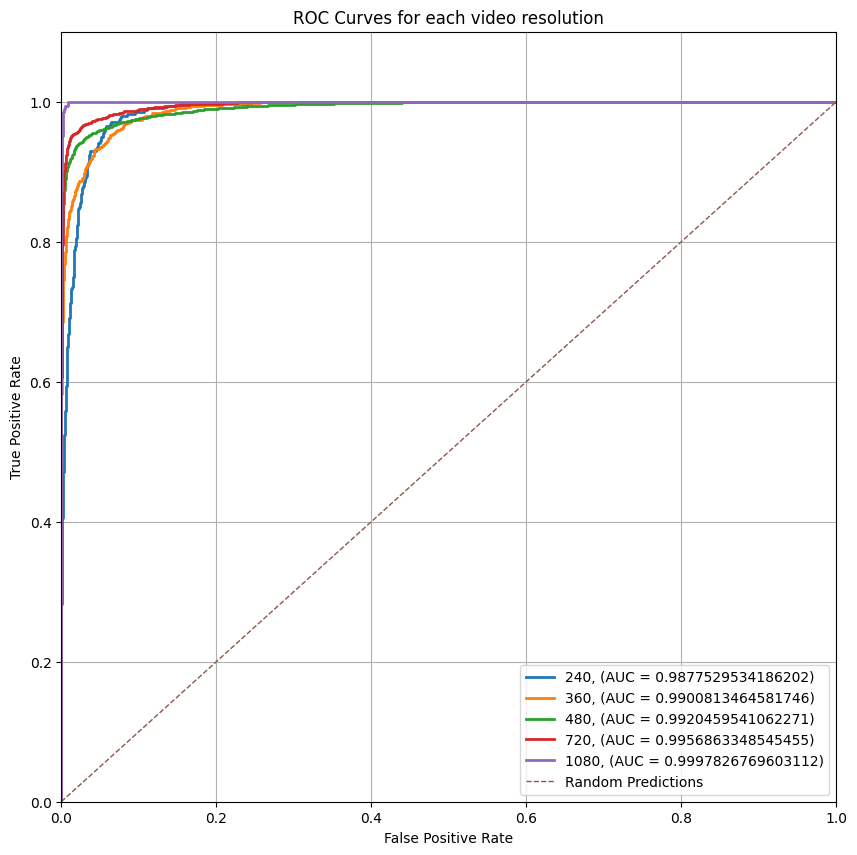

In [284]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

best_model = make_pipeline(SimpleImputer(strategy="median"), RandomForestClassifier(n_estimators=200, max_depth=40, min_samples_split=10, min_samples_leaf=4, class_weight="balanced", n_jobs=-1, random_state=42))
best_model.fit(X_train, y_train)

y_predicted = best_model.predict(X_test)
y_probabilities = best_model.predict_proba(X_test)
classes = [240, 360, 480, 720, 1080]

accuracy = accuracy_score(y_test, y_predicted)
balanced_accuracy = balanced_accuracy_score(y_test, y_predicted)
macro_f1_score = f1_score(y_test, y_predicted, average="macro")
confusion_matrix_plot = confusion_matrix(y_test, y_predicted, labels=classes)

print(f"Accuracy: {accuracy}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Macro F1 Score: {macro_f1_score}")
print("Confusion Matrix:")
print(confusion_matrix_plot)

y_test_label_matrix = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    curr_class = classes[i]
    curr_groundtruths = y_test_label_matrix[:, i]
    curr_probabilities = y_probabilities[:, i]
    false_positive_rate, true_positive_rate, _ = roc_curve(curr_groundtruths, curr_probabilities)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, lw=2, label=f"{curr_class}, (AUC = {area_under_curve})")

plt.plot([0, 1], [0, 1], linestyle="--", lw=1, label="Random Predictions")
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for each video resolution")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

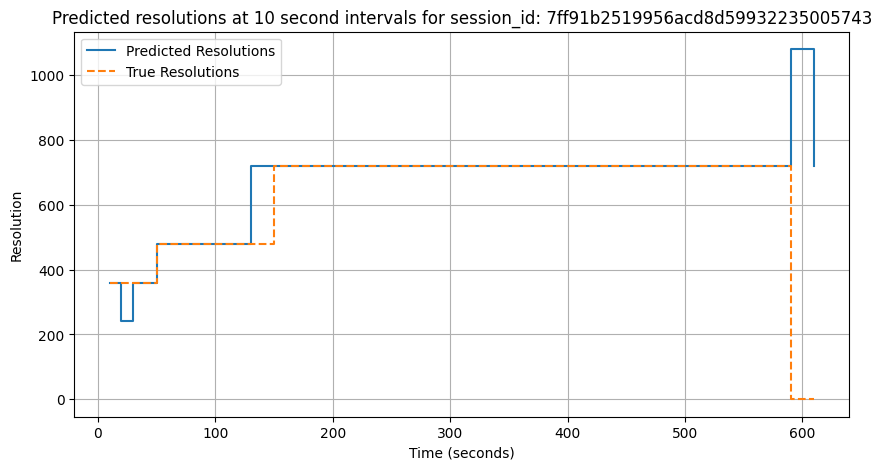

In [285]:
unfiltered_netflix_trace = pd.read_pickle("data/netflix_dataset.pkl")

session_id_inference = unfiltered_netflix_trace["session_id"].iloc[0]
session_data = unfiltered_netflix_trace[unfiltered_netflix_trace["session_id"] == session_id_inference].copy()
session_data.sort_values("relative_timestamp")

timestamps = session_data["relative_timestamp"]
timestamps = pd.to_numeric(timestamps, errors="coerce")

session_for_inference = session_data.reindex(columns=X.columns)

predicted_resolutions = best_model.predict(session_for_inference)
groundtruth_resolutions = session_data["resolution"]

plt.figure(figsize=(10, 5))
plt.step(timestamps, predicted_resolutions, where="post", label="Predicted Resolutions")
plt.step(timestamps, groundtruth_resolutions, where="post", label="True Resolutions", linestyle="--")

plt.xlabel("Time (seconds)")
plt.ylabel("Resolution")
plt.title(f"Predicted resolutions at 10 second intervals for session_id: {session_id_inference}")
plt.legend()
plt.grid(True)
plt.show()
